<a href="https://colab.research.google.com/github/Yoavvvvvv/Image-Processing/blob/main/VAE_mnist_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras.losses import mse
from keras import backend as K
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize the data
x_train = x_train / 255
x_test = x_test / 255

#reshaping the images to (28,28)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)

x_train.shape:  (60000, 28, 28, 1)
x_test.shape:  (10000, 28, 28, 1)


In [5]:
batch_size = 60

In [6]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    return loss + kl_loss

In [7]:
def noiser(args):
    global mean, log_var
    mean, log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

##Variational autoencoder train

In [8]:
input_shape = (28, 28, 3)
hidden_dim = 100

In [9]:
# Encoder
input_image = Input(batch_shape=(batch_size, 28, 28, 1))
x = Flatten()(input_image)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(BatchNormalization()(x))
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(BatchNormalization()(x))

In [10]:
# Define the mean and log-variance layers
mean = Dense(hidden_dim)(x)
log_var = Dense(hidden_dim)(x)
h = Lambda(noiser, output_shape=(hidden_dim), name="latent_space")([mean, log_var])

In [11]:
input_decoder = Input(shape=(hidden_dim,))
d = Dense(128, activation="relu")(input_decoder)
d = Dropout(0.3)(BatchNormalization()(d))
d = Dense(256, activation="relu")(d)
d = Dropout(0.3)(BatchNormalization()(d))
d = Dense(28*28, activation="sigmoid")(d)
decoded = Reshape((28, 28, 1))(d)

In [12]:
encoder = keras.Model(input_image, h, name="encoder")
decoder = keras.Model(input_decoder, decoded, name="decoder")
vae = keras.Model(input_image, decoder(encoder(input_image)), name="vae")
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(60, 28, 28, 1)]         0         
                                                                 
 encoder (Functional)        (60, 100)                 261192    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         248976    
                                                                 
Total params: 510168 (1.95 MB)
Trainable params: 508632 (1.94 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [13]:
epochs = 25

history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Epoch 1/25
1000/1000 [==============================] - 28s 24ms/step - loss: 72.5966
Epoch 2/25
1000/1000 [==============================] - 24s 24ms/step - loss: 44.8669
Epoch 3/25
1000/1000 [==============================] - 22s 22ms/step - loss: 42.6806
Epoch 4/25
1000/1000 [==============================] - 16s 15ms/step - loss: 40.2709
Epoch 5/25
1000/1000 [==============================] - 20s 20ms/step - loss: 38.6821
Epoch 6/25
1000/1000 [==============================] - 17s 17ms/step - loss: 37.9486
Epoch 7/25
1000/1000 [==============================] - 15s 15ms/step - loss: 37.6347
Epoch 8/25
1000/1000 [==============================] - 15s 15ms/step - loss: 37.3685
Epoch 9/25
1000/1000 [==============================] - 15s 15ms/step - loss: 37.1441
Epoch 10/25
1000/1000 [==============================] - 17s 17ms/step - loss: 36.9152
Epoch 11/25
1000/1000 [==============================] - 15s 15ms/step - loss: 36.7626
Epoch 12/25
1000/1000 [=============================

## Generating new image from the latent space distribution

In [20]:
def generate_images(vae, num_images):
    # Sample random points from the latent space
    latent_points = np.random.normal(size=(num_images, hidden_dim))  # Assuming latent_dim is the dimensionality of the latent space

    # Decode the latent points into images
    decoded_images = decoder.predict(latent_points)

    return decoded_images

1/1 [==============================] - 0s 22ms/step


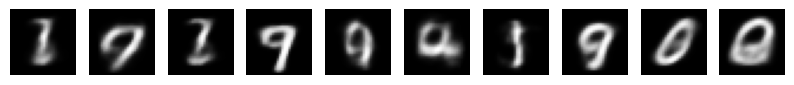

In [21]:

# Generate new images using the trained VAE
num_images_to_generate = 10  # Specify the number of images to generate
generated_images = generate_images(vae, num_images_to_generate)

# Display the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [27]:
generated_images.shape

(10, 28, 28, 1)

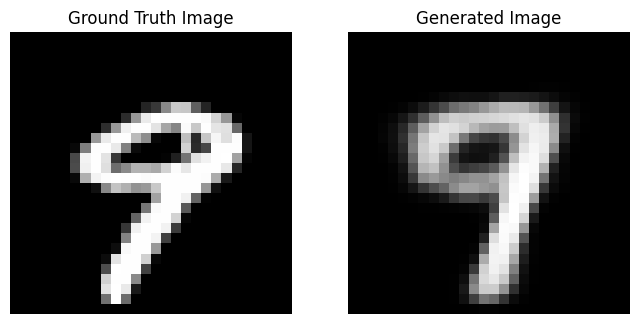

In [32]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test[9], cmap='gray')
plt.title('Ground Truth Image')
plt.axis('off')

# Plot generated image next to the ground truth image
plt.subplot(1, 2, 2)
plt.imshow(generated_images[3].reshape(28, 28), cmap='gray')
plt.title('Generated Image')
plt.axis('off')

plt.show()


#VEA classification

### Generating new images from random point in the latent space

In [33]:
encoded_data= encoder.predict(x_test[:3000], batch_size=batch_size)

50/50 [==============================] - 0s 4ms/step


<ipython-input-38-9ab069dbf109>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(encoded_data[:,0], encoded_data[:,1], cmap='brg')


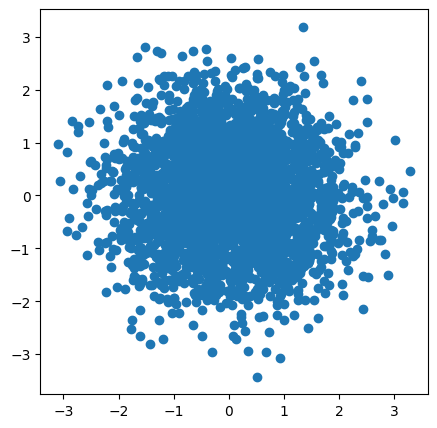

In [38]:
plt.figure(figsize=(5, 5))
plt.scatter(encoded_data[:,0], encoded_data[:,1], cmap='brg')
plt.show()

In [39]:
def generate_images(vae, num_images):
    latent_points = np.random.normal(size=(num_images, hidden_dim))  # Assuming latent_dim is the dimensionality of the latent space
    decoded_images = decoder.predict(latent_points)

    return decoded_images, latent_points

1/1 [==============================] - 0s 21ms/step


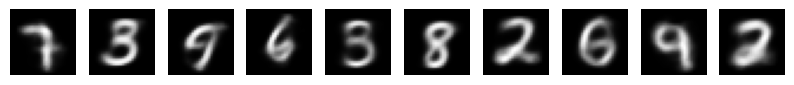

In [40]:
generated_images, latent_points_to_plot = generate_images(vae, num_images_to_generate)

# Display the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

<ipython-input-42-b25f586a6975>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_points_to_plot[:,0], latent_points_to_plot[:,1], cmap='brg')


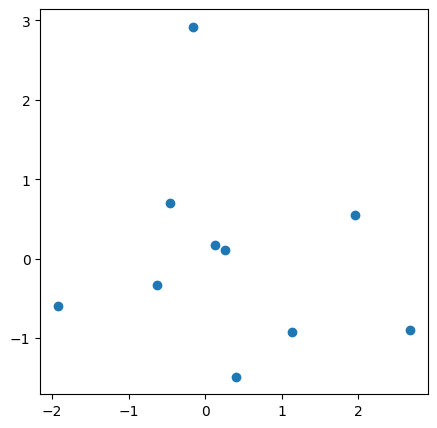

In [42]:
#ploting the generated image location in the latent space distribution

plt.figure(figsize=(5, 5))
plt.scatter(latent_points_to_plot[:,0], latent_points_to_plot[:,1], cmap='brg')
plt.show()